# Tonnetz Diffusion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

sns.set_context('talk')

import numpy as np
import statsmodels.api as sm
from scipy.stats import entropy

In [2]:
intervals = ['+P5', '-P5', '+m3', '-m3', '+M3', '-M3']

In [3]:
def plot_parameters(df, c_range, labels=None):
    
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for i, l, ax in zip(range(c_range[0], c_range[1]+1), labels, axes):
        sc = sns.regplot(
            x='year', 
            y=str(i), 
            data=df[df[str(i)]>0], 
            scatter_kws={'alpha':.3}, 
            line_kws={'color':'k'},
            marker='+',
            lowess=True,
            ax=ax
        )
        ax.set_ylabel(l)
        ax.set_xlabel('')
        ax.set_ylim(0,1)
    plt.tight_layout()
    return fig

In [4]:
def bootstrap_lowess(df, c_range, labels=None, B=100, scatter=True, colors=None):
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for i, l, ax in zip(range(c_range[0], c_range[1]+1), labels, axes):
        if scatter:
            sns.regplot(
            x='year', 
            y=str(i), 
            data=df[df[str(i)]>0], 
            scatter_kws={'alpha':.2}, 
            marker='+',
            fit_reg=False,
            ax=ax
        )
        
        for b in range(B):
            b_sample = df[[str(i), 'year']].sample(df.shape[0], replace=True)

            x = b_sample.year.values
            y = b_sample[str(i)].values
            lowess = sm.nonparametric.lowess(y, x, frac=0.3)

            ax.plot(lowess[:, 0], lowess[:, 1], alpha=.05, c=colors[i%6]['color'])
        ax.set_ylabel(l)

    plt.tight_layout()
    return fig

read csv with a single decay parameter for all primary intervals

In [120]:
cols = ['JSDs'] + [str(i) for i in range(7)] + ['file'] + ['composer'] + ['year']
df = pd.read_csv('results_1.tsv', sep='\t', names=cols, header=0).sort_values(by='year')
df.head()

JSDs         0         1             2             3             4  \
1444  0.092486  0.255935  0.596187  2.648247e-15  1.478780e-01  2.942648e-14   
1442  0.083541  0.327432  0.672568  1.960515e-14  9.361018e-17  1.794225e-15   
1443  0.062455  0.864880  0.135120  0.000000e+00  0.000000e+00  0.000000e+00   
1445  0.043759  0.594580  0.405420  0.000000e+00  0.000000e+00  0.000000e+00   
1400  0.045719  0.554466  0.445534  1.090960e-15  1.044985e-15  2.539127e-16   

                 5         6  \
1444  5.135263e-15  0.754118   
1442  3.176223e-15  0.838463   
1443  0.000000e+00  0.758734   
1445  0.000000e+00  0.850403   
1400  3.602378e-16  0.841752   

                                                   file composer    year  
1444  ..\ExtendedTonality\data\DataFrames\Lugentium-...    Vitry  1361.0  
1442  ..\ExtendedTonality\data\DataFrames\Virtutibus...    Vitry  1361.0  
1443  ..\ExtendedTonality\data\DataFrames\Gratissima...    Vitry  1361.0  
1445  ..\ExtendedTonality\data\DataFrames\Rex-quem-m...    Vitry  1361.0  
1400  ..\ExtendedTonality\data\DataFrames\Messe-de-N...  Machaut  1370.0

In [121]:
df['tonal_center'] = df['file'].apply(lambda x: pd.read_csv(x, engine='python').tpc.value_counts().idxmax())

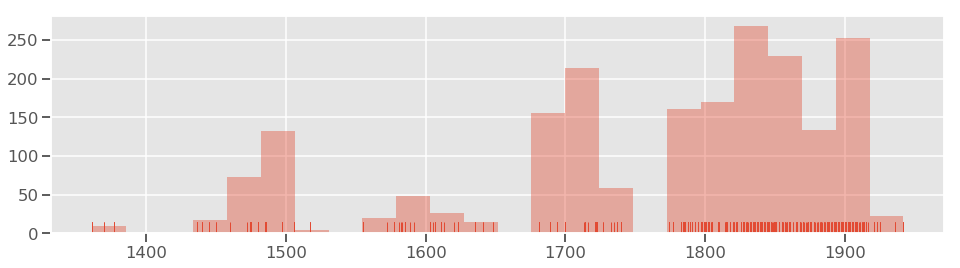

In [122]:
fig, ax = plt.subplots(figsize=(16,4))
sns.distplot(df.year.dropna(), rug=True, kde=False,norm_hist=False)
plt.xlabel('')
plt.savefig("img/corpus.png", dpi=300);

## Interval weights

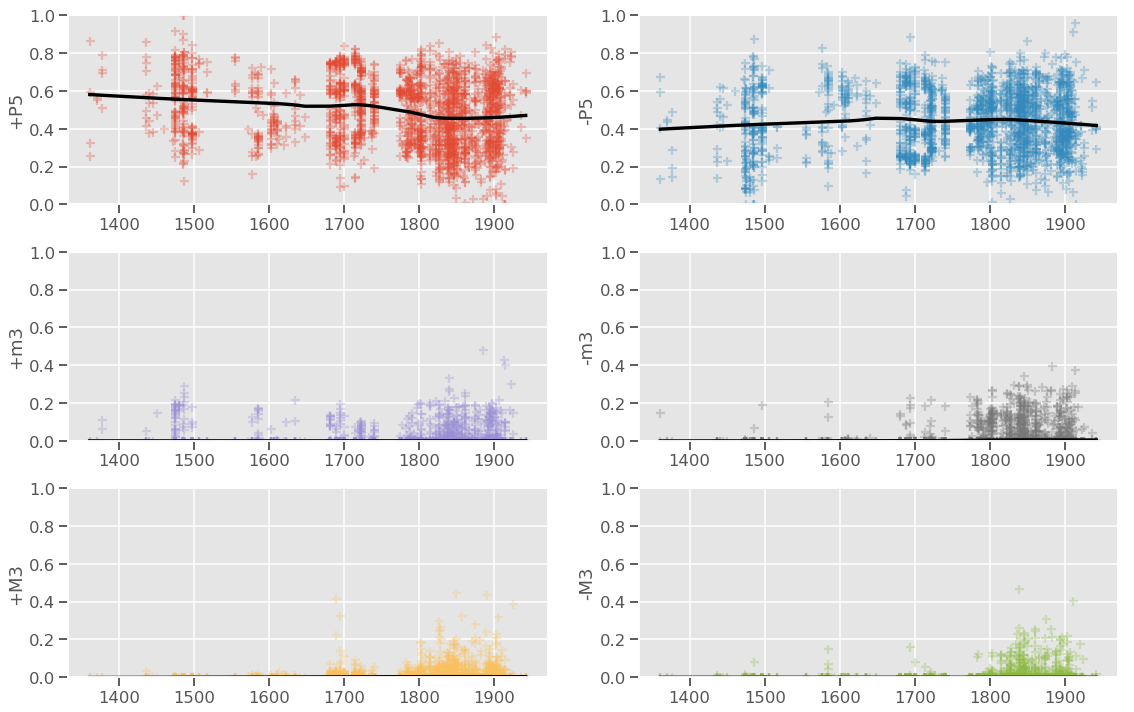

In [123]:
fig = plot_parameters(df, [0,5], labels=intervals)
plt.savefig('img/interval_weights.png', dpi=300)

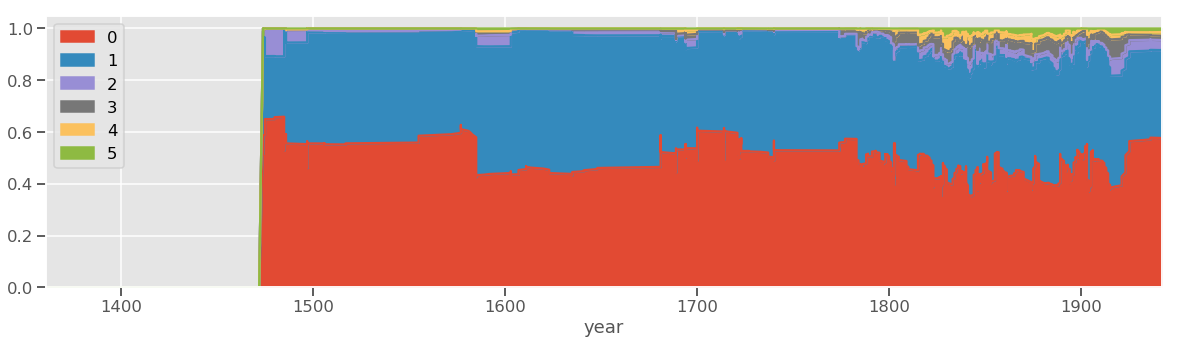

In [124]:
stacked = df.loc[:,[str(i) for i in range(6)]].rolling(window=30, win_type='cosine', center=False).mean()
stacked.index = df.year
stacked.plot(kind='area', figsize=(20,5))

plt.margins(0,0);

In [125]:
catcolors = list(plt.rcParams['axes.prop_cycle'])

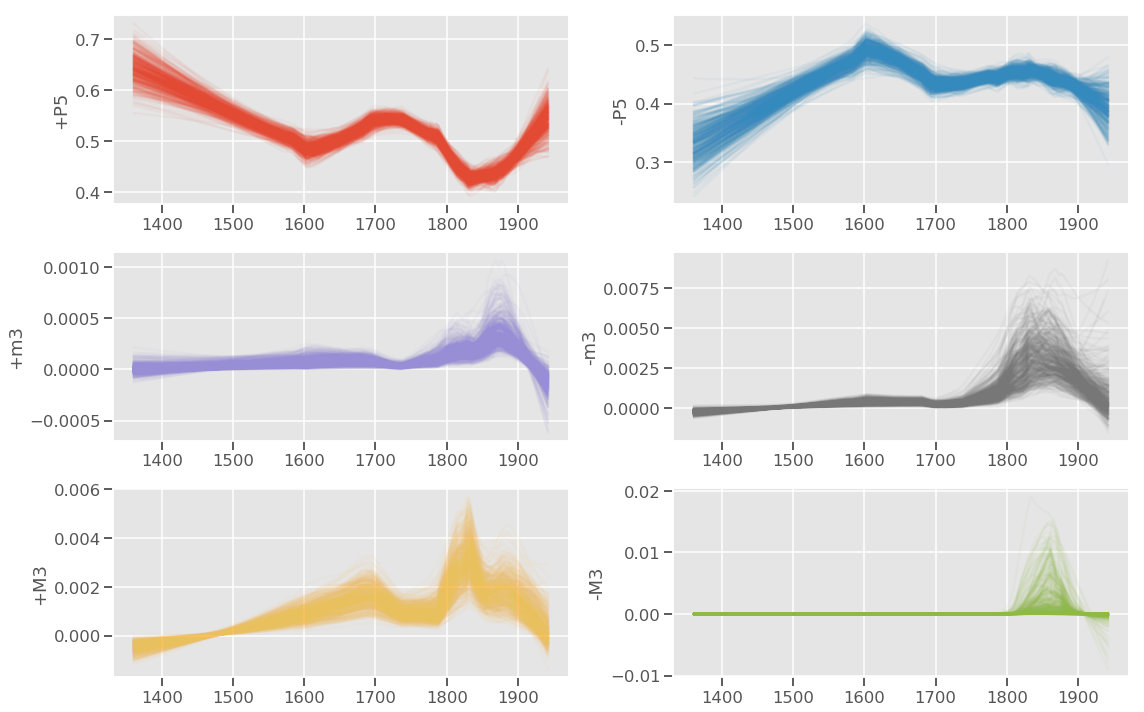

In [126]:
fig = bootstrap_lowess(df, [0,5], scatter=False, B=500, labels=intervals, colors=catcolors)
plt.savefig('img/bootstrapped_weights.png', dpi=300)

Observations:
* It seems that there are strong correlations between +m3 and -M3 (major triad), and between -m3 and +M3 (minor triad). Viewed absolutely, the major triad components are stronger (because minor is a mixed mode?)
* If also taking the fifths into account: how do dualistic theories play out?
* +P5 and -P5 are almost inverse patterns "W" and "M" (slightly shifted in time towards the end)

## Diffusion parameter

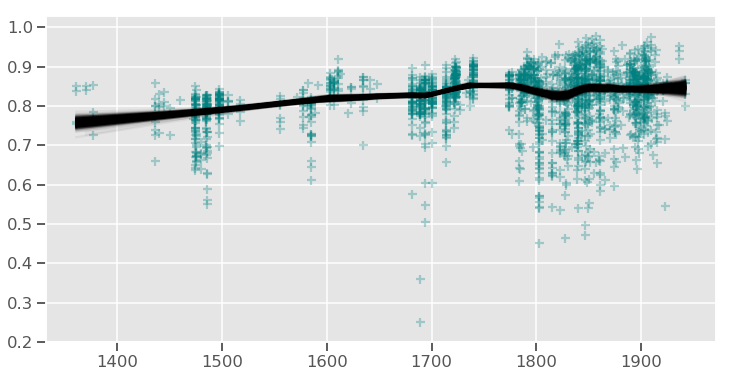

In [152]:
B = 500

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(df['year'], df['6'], alpha=.3, marker='+', color='teal')

for b in range(B):
    b_sample = df[[str(6), 'year']].sample(df.shape[0], replace=True)

    x = b_sample.year.values
    y = b_sample[str(6)].values
    lowess = sm.nonparametric.lowess(y, x, frac=0.3)

    ax.plot(lowess[:, 0], lowess[:, 1], alpha=.05, c='k')
    
plt.savefig("img/bootstrapped_decay.png", dpi=300)

## Divergences from true distributions per composer

In [131]:
df['sqrtJSDs'] = df['JSDs'].apply(np.sqrt)

In [132]:
df.sqrtJSDs.max()

0.39927201947706936

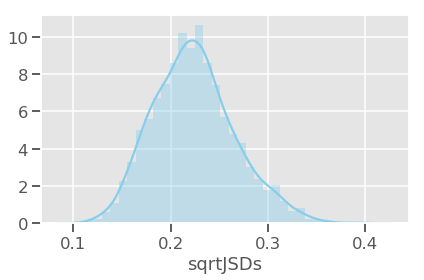

In [133]:
sns.distplot(df.sqrtJSDs, color='skyblue')
plt.tight_layout()
# plt.savefig('img/JSDs_dist.png', dpi=300);

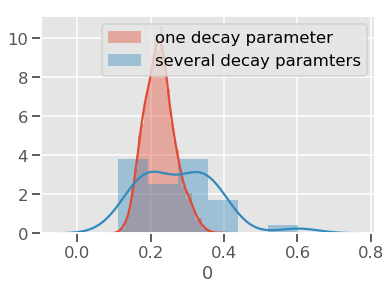

In [134]:
df1 = pd.read_csv('results_1.tsv', sep='\t')
df6 = pd.read_csv('results_6.tsv', sep='\t')
sns.distplot(df1.iloc[:,0].apply(np.sqrt), label='one decay parameter')
sns.distplot(df6.iloc[:,0].apply(np.sqrt), label='several decay paramters')
plt.legend();

It doesn't seem to make a difference whether there is one global decay parameter (per piece) or one for each interval.

The global parameter values are largely determined by the fifths (+/-P5). Since the third components (+/-m3, +/-M3) are relatively weak they don't fall into the weight.

What would be an objective measure to show that it is better to include decay parameters for all intervals separately? The $d_JS$ values are not sufficiently different. It _should_ be the case that if the global decay parameter is high (around .8) that the third components are much weaker because everything is already covered by the fifths.

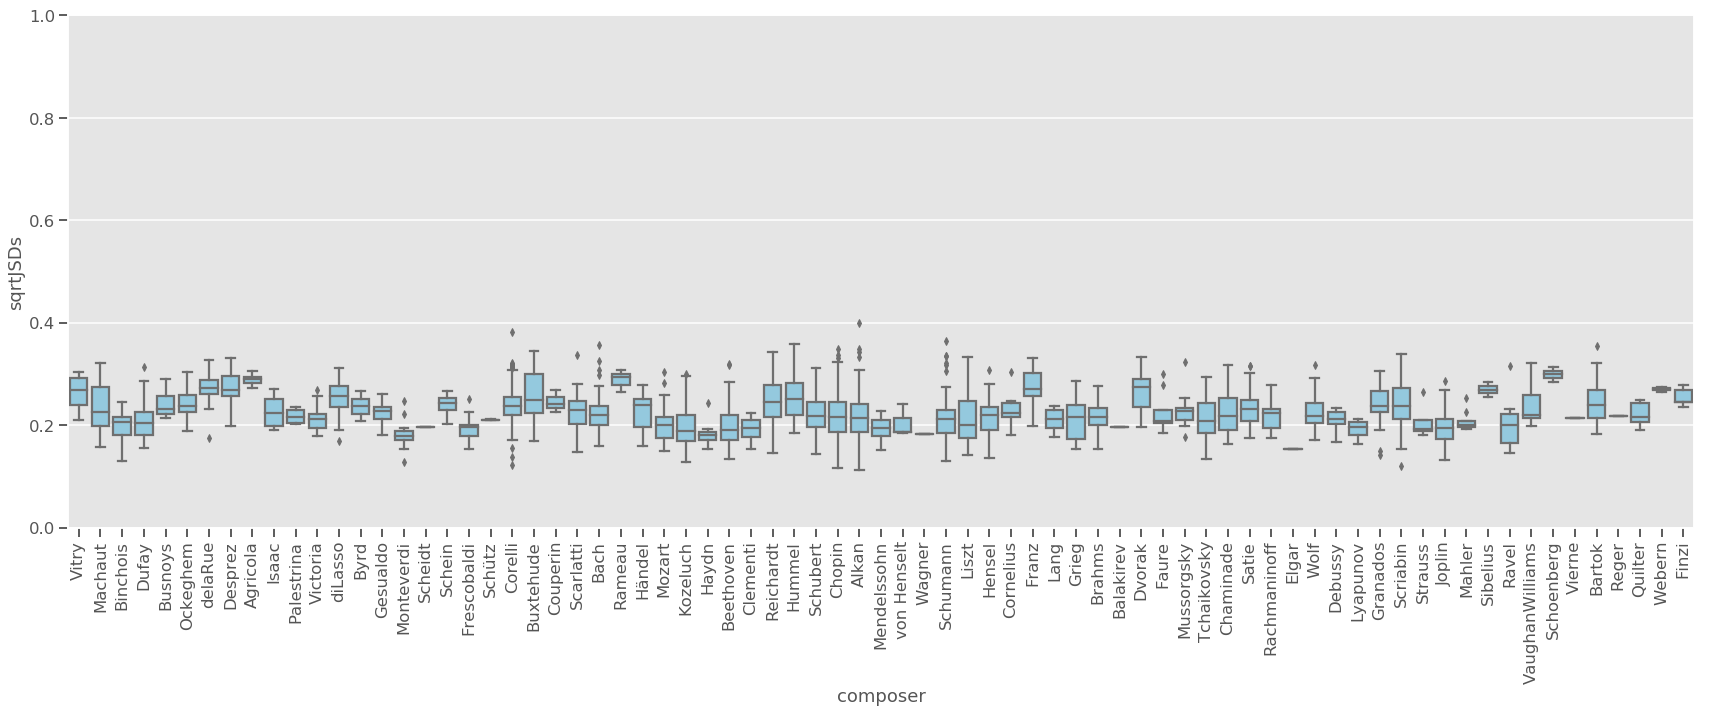

In [136]:
fig, ax = plt.subplots(figsize=(24,10))

sns.boxplot(
    x="composer", 
    y="sqrtJSDs",
    color='skyblue',
    data=df, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()
plt.ylim(0,1)
# plt.savefig('img/JSDs_composers.png', dpi=300)
plt.show()

In [20]:
best = df.loc[df.sqrtJSDs.idxmin()]
best

JSDs                                                0.0122572
0                                                    0.291518
1                                                    0.450456
2                                                   0.0838312
3                                                    0.126512
4                                                   0.0274615
5                                                   0.0202213
6                                                     0.80718
7                                                    0.937718
8                                                    0.655795
9                                                    0.649903
10                                                    0.52406
11                                                   0.599993
file        ..\ExtendedTonality\data\DataFrames\Scherzo_Fo...
composer                                                Alkan
year                                                     1847
sqrtJSDs

In [21]:
worst = df.loc[df.sqrtJSDs.idxmax()]
worst

JSDs                                                 0.160024
0                                                    0.391691
1                                                    0.168153
2                                                    0.274584
3                                                 3.46159e-19
4                                                   0.0818809
5                                                    0.083691
6                                                    0.756891
7                                                    0.496177
8                                                    0.836205
9                                                    0.188351
10                                                  0.0740605
11                                                   0.736131
file        ..\ExtendedTonality\data\DataFrames\Un_Morceau...
composer                                                Alkan
year                                                     1840
sqrtJSDs

### Symmetry (dualistic perspective)
#### Parameter weights

In [22]:
ints = df[[str(i) for i in range(6)]].copy()
ints = ints.melt()
ints.variable = ints.variable.astype(int)
ints['direction'] = np.where(ints['variable'].apply(pd.to_numeric) % 2 == 0, 'acending', 'descending')
ints['interval'] = ['P5' if s in (0,1) else 'm3' if s in (2,3) else 'M3' if s in (4,5) else '' for s in ints.variable.values]
ints.head()

variable     value direction interval
0         0  0.546899  acending       P5
1         0  0.340914  acending       P5
2         0  0.669057  acending       P5
3         0  0.561634  acending       P5
4         0  0.526563  acending       P5

How does the symmetry change over time? Could the 19th century theorists have been "mislead" by contemporary music?

#### Parameter decays

In [23]:
dec = df[[str(i) for i in range(6,12)]].copy()
dec = dec.melt()
dec.variable = dec.variable.astype(int)
dec['direction'] = np.where(dec['variable'].apply(pd.to_numeric) % 2 == 0, 'acending', 'descending')
dec['interval'] = ['P5' if s in (6,7) else 'm3' if s in (8,9) else 'M3' if s in (10,11) else '' for s in dec.variable.values]
dec.head()

variable     value direction interval
0         6  0.825137  acending       P5
1         6  0.733203  acending       P5
2         6  0.981455  acending       P5
3         6  0.893876  acending       P5
4         6  0.886907  acending       P5

#### Plot

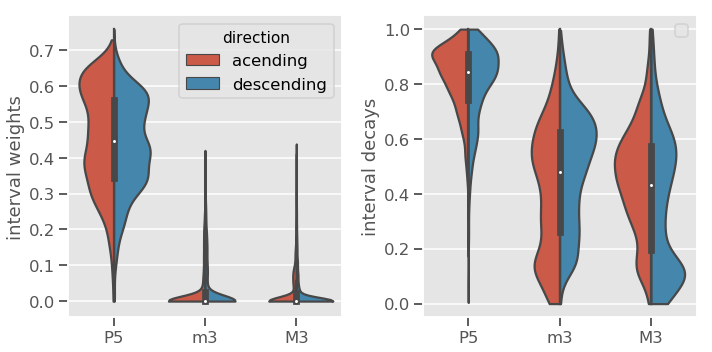

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.violinplot(
    data=ints, 
    x='interval', 
    y='value', 
    hue='direction', 
    split=True,
    cut=0,
    ax=axes[0],
)
axes[0].set_ylabel('interval weights')
axes[0].set_xlabel('')

sns.violinplot(
    data=dec, 
    x='interval', 
    y='value', 
    hue='direction', 
    split=True,
    cut=0,
    ax=axes[1]
)
axes[1].set_ylabel('interval decays')
axes[1].set_xlabel('')
axes[1].legend('')

plt.tight_layout()
plt.savefig('img/parameter_dists.png', dpi=300);

### Parameter Clustering

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [8]:
for i in [0,2,4]:
    df[str(i)+"-"+str(i+1)] = df[str(i)] + df[str(i+1)]

In [9]:
ints_df = df.iloc[:,-3:]

In [64]:
d = dict(
    zip(
        df.tonal_center.unique(),
        [i for i in range(df.tonal_center.unique().shape[0])]
    )
)
d

{'G': 0,
 'A': 1,
 'F': 2,
 'D': 3,
 'C': 4,
 'B': 5,
 'E': 6,
 'Bb': 7,
 'F#': 8,
 'C#': 9,
 'G#': 10,
 'Eb': 11,
 'Ab': 12,
 'A#': 13,
 'D#': 14,
 'Db': 15,
 'Gb': 16}

In [96]:
X_ = df.loc[:,[str(i) for i in range(0,12)]]

# multiply gammas by weights
# for i in range(6):
#     X_[str(i+6)] = X_[str(i)] * X_[str(i+6)]

n = 12
pca = PCA(n_components=n)
Y_ = pca.fit_transform(X_)

In [97]:
[pca.explained_variance_ratio_[i] for i in range(n)]

[0.5042636075585263,
 0.20723397048785439,
 0.13643729472536573,
 0.06009614140255946,
 0.0477538996454425,
 0.018014829740516932,
 0.007763256209983059,
 0.007089190453034579,
 0.005576415431407041,
 0.0038314428824063477,
 0.0019399511880091574,
 2.7489468027656503e-10]

In [98]:
df['PC1'] = Y_[:,0]
df['PC2'] = Y_[:,1]
df['PC3'] = Y_[:,2]

In [99]:
pca_composers = df.groupby('composer')[['PC1', 'PC2']].median()

In [100]:
df.head()

JSDs         0         1             2             3             4  \
1444  0.084306  0.546899  0.453101  1.145053e-16  0.000000e+00  3.797418e-17   
1442  0.082131  0.340914  0.632240  7.403419e-19  3.151637e-03  2.369442e-02   
1443  0.062455  0.669057  0.241962  3.861786e-02  9.336871e-13  1.611529e-13   
1445  0.042667  0.561634  0.438366  4.000629e-17  8.746670e-17  1.521919e-16   
1400  0.045719  0.526563  0.473437  1.429368e-16  1.485737e-16  9.523765e-18   

                 5         6         7             8    ...     \
1444  0.000000e+00  0.825137  0.881071  4.187719e-01    ...      
1442  8.765961e-17  0.733203  0.893502  6.852771e-01    ...      
1443  5.036231e-02  0.981455  0.423207  5.527872e-13    ...      
1445  7.014793e-17  0.893876  0.771316  3.005533e-01    ...      
1400  1.660025e-17  0.886907  0.791428  4.347314e-01    ...      

                                                   file  composer    year  \
1444  ..\ExtendedTonality\data\DataFrames\Lugentium-...     Vitry  1361.0   
1442  ..\ExtendedTonality\data\DataFrames\Virtutibus...     Vitry  1361.0   
1443  ..\ExtendedTonality\data\DataFrames\Gratissima...     Vitry  1361.0   
1445  ..\ExtendedTonality\data\DataFrames\Rex-quem-m...     Vitry  1361.0   
1400  ..\ExtendedTonality\data\DataFrames\Messe-de-N...   Machaut  1370.0   

     tonal_center       0-1           2-3           4-5       PC1       PC2  \
1444            G  1.000000  1.145053e-16  3.797418e-17 -0.140263 -0.066511   
1442            A  0.973154  3.151637e-03  2.369442e-02  0.631592 -0.281293   
1443            F  0.911020  3.861786e-02  5.036231e-02 -0.720867 -0.117838   
1445            G  1.000000  1.274730e-16  2.223399e-16 -0.297666 -0.052894   
1400            D  1.000000  2.915106e-16  2.612402e-17 -0.076152 -0.206845   

           PC3  
1444  0.035638  
1442  0.094341  
1443 -0.178605  
1445  0.001195  
1400  0.001741  

[5 rows x 23 columns]

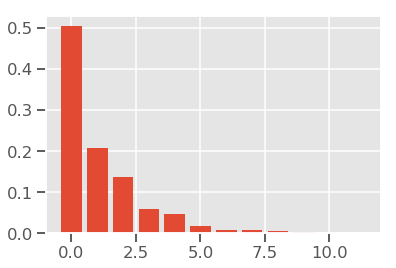

In [102]:
plt.bar(np.arange(n),pca.explained_variance_ratio_);

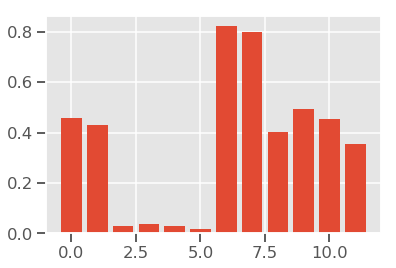

In [103]:
plt.bar(np.arange(n),pca.mean_);

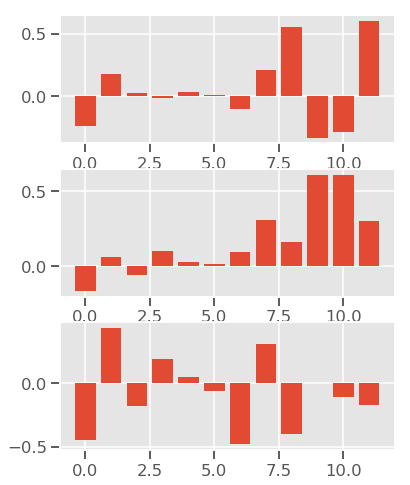

In [105]:
fig, axes = plt.subplots(3,1, figsize=(6,8))
for v, ax in zip(pca.components_[:3], axes):
#     ax.bar(np.arange(12),v, alpha=.5)
    ax.bar(np.arange(n),v)

---> use the principle components and plot the diffusion model for these settings

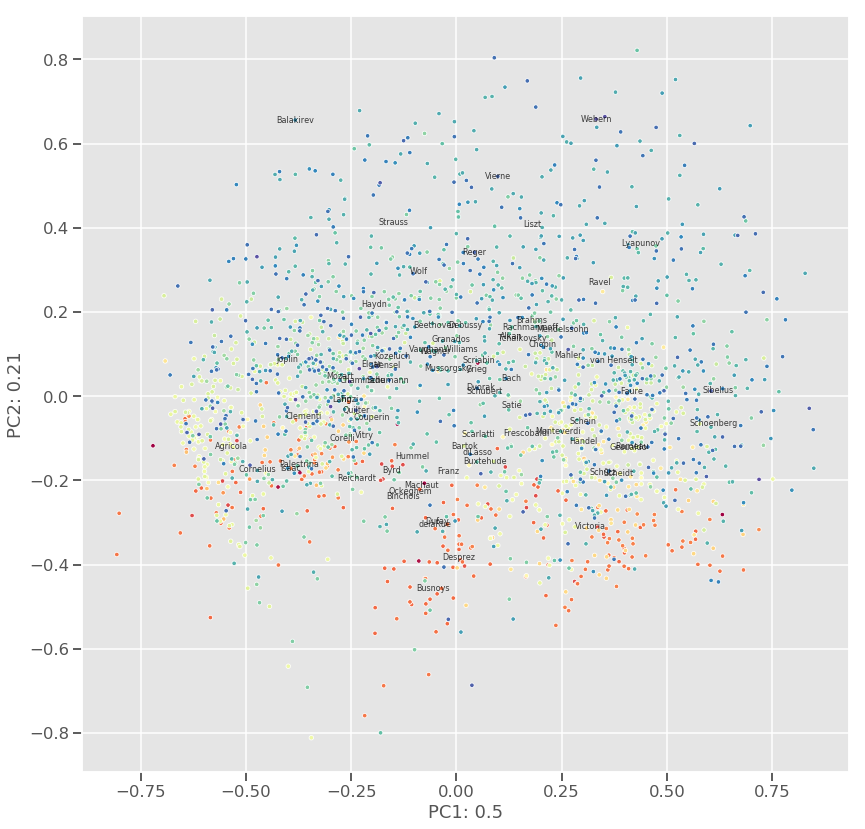

In [110]:
fig, ax = plt.subplots(figsize=(12,12))

ax.set_aspect('equal')
sns.scatterplot(Y_[:,0], Y_[:,1], alpha=1, marker='.', hue=df['year'], palette='Spectral', ax=ax)

for c, (x,y) in pca_composers.iterrows():
    ax.text(x,y,c, alpha=.75, va='center', ha='center', fontsize=8)
    
ax.set_xlabel("PC1: " + str(round(pca.explained_variance_ratio_[0],2)))
ax.set_ylabel("PC2: " + str(round(pca.explained_variance_ratio_[1],2)))
    
ax.get_legend().remove()
plt.tight_layout()
plt.savefig("img/TDM_PCA.png", dpi=600);

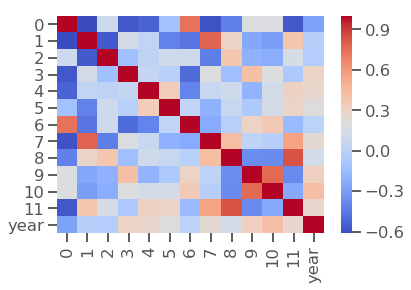

In [197]:
sns.heatmap(df[[str(i) for i in range(12)]+['year']].corr(), cmap='coolwarm')

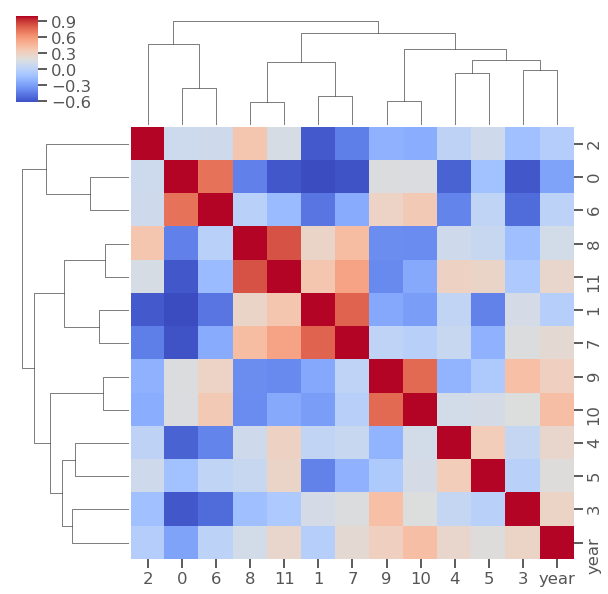

In [198]:
sns.clustermap(df[[str(i) for i in range(12)]+['year']].corr(), cmap='coolwarm')

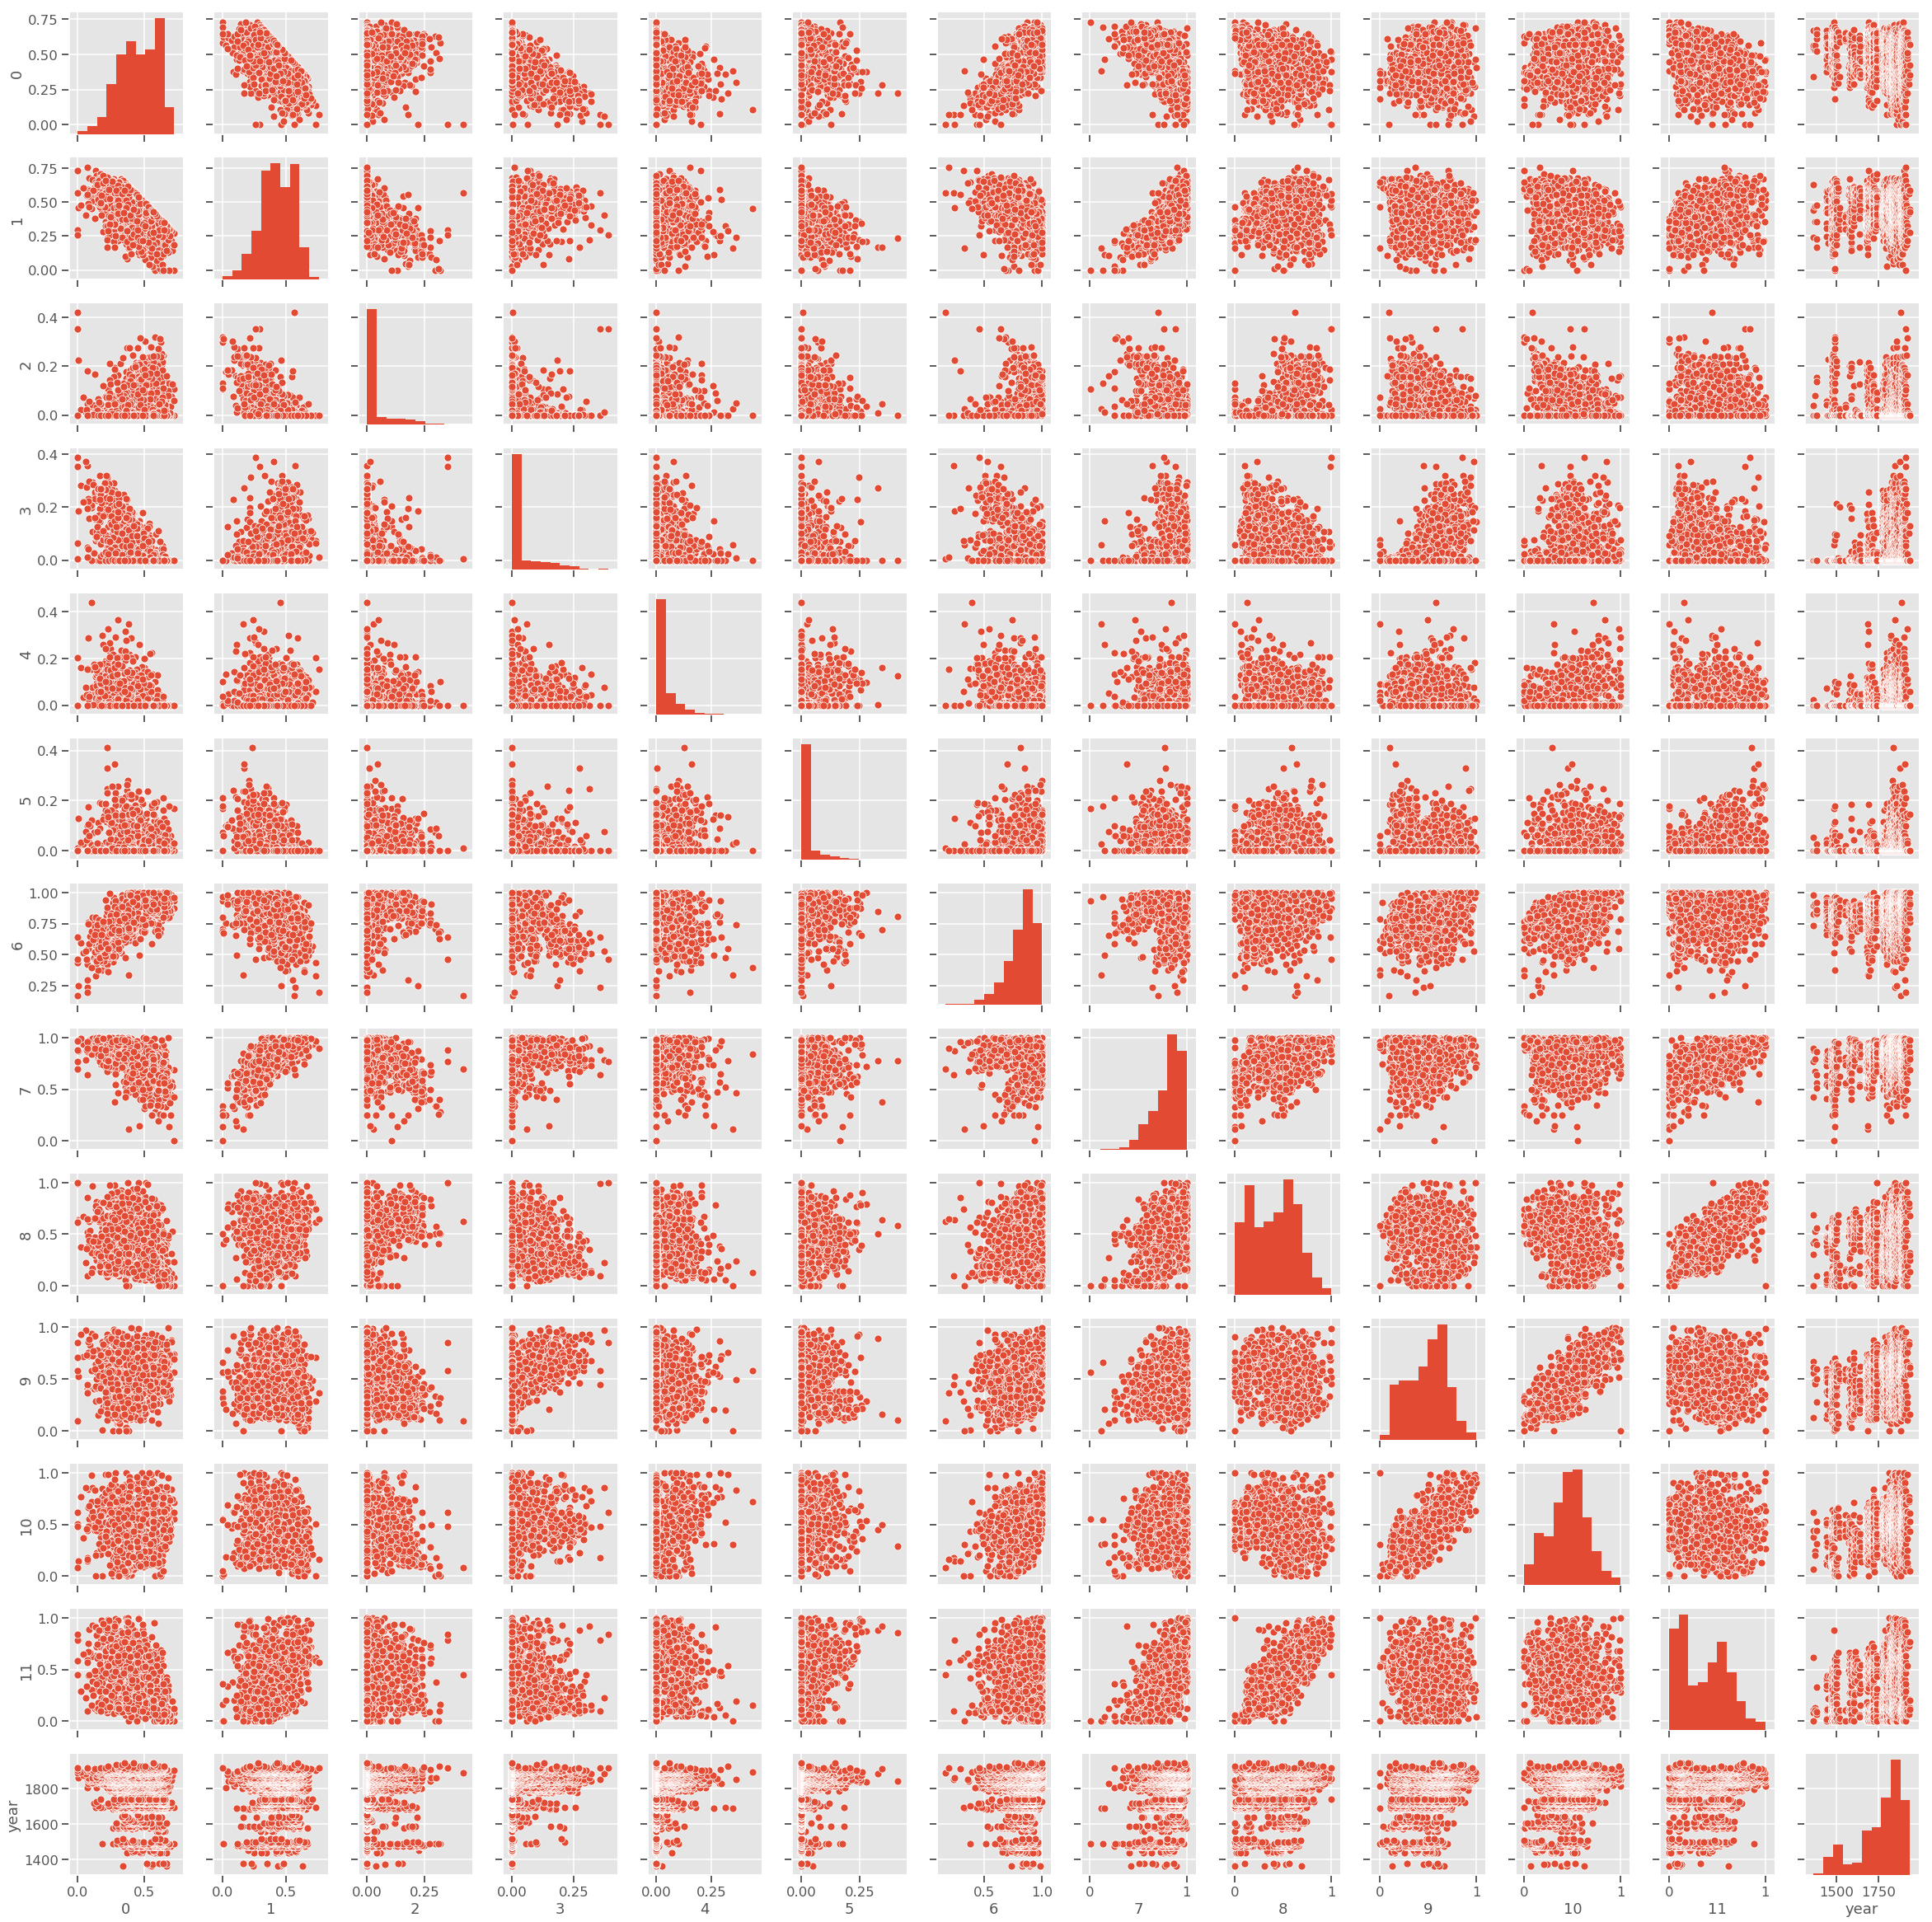

In [184]:
sns.pairplot(df[[str(i) for i in range(12)]+['year']])